## Step 3: Feature engineering & Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
data = pd.read_csv('.\weatherHCM_preprocessed.csv', sep='\t')
data.head(10)

,Date,Time,Weather,Temp,Feels,Gust,Rain,Humidity,Cloud,Pressure,Vis,Wind Speed,Wind Direction
0,"Thu 01, Jan 2009",00:00,Mist,23.0,25.0,15.0,0.0,0.97,1.00,1010.0,Poor,9.0,NNW
1,"Thu 01, Jan 2009",03:00,Rain,22.0,25.0,13.0,0.4,0.97,0.84,1010.0,Poor,9.0,NNW
2,"Thu 01, Jan 2009",06:00,Mist,22.0,25.0,8.0,0.0,0.98,1.00,1011.0,Poor,6.0,N
3,"Thu 01, Jan 2009",09:00,Cloudy,27.0,31.0,7.0,0.1,0.83,0.64,1011.0,Excellent,6.0,NNE
4,"Thu 01, Jan 2009",12:00,Cloudy,28.0,34.0,3.0,0.0,0.76,0.62,1010.0,Excellent,3.0,NE
5,"Thu 01, Jan 2009",15:00,Rain,27.0,32.0,4.0,3.1,0.83,0.74,1009.0,Good,2.0,NNE
6,"Thu 01, Jan 2009",18:00,Cloudy,24.0,27.0,14.0,0.0,0.91,0.73,1010.0,Excellent,7.0,NW
7,"Thu 01, Jan 2009",21:00,Rain,23.0,26.0,18.0,1.6,0.91,0.32,1012.0,Excellent,10.0,NNE
8,"Fri 02, Jan 2009",00:00,Cloudy,22.0,22.0,14.0,0.0,0.91,0.30,1011.0,Excellent,8.0,N
9,"Fri 02, Jan 2009",03:00,Cloudy,21.0,22.0,16.0,0.0,0.91,0.72,1010.0,Excellent,9.0,N


### Đọc dữ liệu đã tiền xử lý từ file

Dùng thuộc tính của 3 khoảng thời gian trước để dự đoán giá trị Temperature ở thời điểm tiếp theo

#trực quan 

In [3]:
#https://stackabuse.com/using-machine-learning-to-predict-the-weather-part-1/
def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

for feature in data.columns:
    if feature != 'Time' and feature != 'Date':
        for N in range(1, 4):
            derive_nth_day_feature(data, feature, N)

data.drop(columns=['Date', 'Weather', 'Feels', 'Gust', 'Rain', 'Humidity', 'Cloud', 'Pressure', 'Wind Speed', 'Wind Direction', 'Vis'], inplace=True)
data = data[3:]
data.reset_index(drop=True, inplace=True)

data.head()

,Time,Temp,Weather_1,Weather_2,Weather_3,Temp_1,Temp_2,Temp_3,Feels_1,Feels_2,...,Pressure_3,Vis_1,Vis_2,Vis_3,Wind Speed_1,Wind Speed_2,Wind Speed_3,Wind Direction_1,Wind Direction_2,Wind Direction_3
0,09:00,27.0,Mist,Rain,Mist,22.0,22.0,23.0,25.0,25.0,...,1010.0,Poor,Poor,Poor,6.0,9.0,9.0,N,NNW,NNW
1,12:00,28.0,Cloudy,Mist,Rain,27.0,22.0,22.0,31.0,25.0,...,1010.0,Excellent,Poor,Poor,6.0,6.0,9.0,NNE,N,NNW
2,15:00,27.0,Cloudy,Cloudy,Mist,28.0,27.0,22.0,34.0,31.0,...,1011.0,Excellent,Excellent,Poor,3.0,6.0,6.0,NE,NNE,N
3,18:00,24.0,Rain,Cloudy,Cloudy,27.0,28.0,27.0,32.0,34.0,...,1011.0,Good,Excellent,Excellent,2.0,3.0,6.0,NNE,NE,NNE
4,21:00,23.0,Cloudy,Rain,Cloudy,24.0,27.0,28.0,27.0,32.0,...,1010.0,Excellent,Good,Excellent,7.0,2.0,3.0,NW,NNE,NE


**Tính độ tương quan giữa các thuộc tính số với Temp**

In [4]:
corr = data.select_dtypes(include='number').corr()[['Temp']].sort_values('Temp')
corr

,Temp
Humidity_1,-0.593766
Temp_3,-0.201505
Gust_2,-0.200011
Feels_3,-0.185120
Gust_3,-0.161530
Humidity_2,-0.154154
Cloud_2,-0.142889
Gust_1,-0.123309
Cloud_1,-0.121738
Rain_3,-0.119025


Bỏ các cột có |correlation| < 0.5

In [5]:
data.drop(columns=[col for col in corr.index if abs(corr['Temp'].loc[col]) < 0.5], inplace=True)

**Chọn thuộc tính categorical cho việc dự đoán**

In [6]:
data.drop(columns=['Wind Direction_1', 'Wind Direction_2', 'Wind Direction_3', 'Vis_1', 'Vis_2', 'Vis_3'], inplace=True)
data.head()

,Time,Temp,Weather_1,Weather_2,Weather_3,Temp_1,Feels_1,Humidity_1
0,09:00,27.0,Mist,Rain,Mist,22.0,25.0,0.98
1,12:00,28.0,Cloudy,Mist,Rain,27.0,31.0,0.83
2,15:00,27.0,Cloudy,Cloudy,Mist,28.0,34.0,0.76
3,18:00,24.0,Rain,Cloudy,Cloudy,27.0,32.0,0.83
4,21:00,23.0,Cloudy,Rain,Cloudy,24.0,27.0,0.91


##Mã hóa các giá trị phân loại

In [7]:
# mã hóa một nóng
cols_object = [col for col in data.columns if data[col].dtype=='object']
for col in cols_object:
    dummies = pd.get_dummies(data[col], prefix=col)
    data.drop(columns=[col], inplace=True)
    data = pd.concat([data, dummies], axis=1)

data.head()

,Temp,Temp_1,Feels_1,Humidity_1,Time_00:00,Time_03:00,Time_06:00,Time_09:00,Time_12:00,Time_15:00,...,Weather_2_Mist,Weather_2_Overcast,Weather_2_Rain,Weather_2_Sunny,Weather_3_Clear,Weather_3_Cloudy,Weather_3_Mist,Weather_3_Overcast,Weather_3_Rain,Weather_3_Sunny
0,27.0,22.0,25.0,0.98,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
1,28.0,27.0,31.0,0.83,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,True,False
2,27.0,28.0,34.0,0.76,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,24.0,27.0,32.0,0.83,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,23.0,24.0,27.0,0.91,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False


### Model

**Chuẩn bị dữ liệu**

In [8]:
X = np.random.rand(100, 1) * 10
y = 3 * X**2 + 2 * X + 5 + np.random.randn(100, 1) * 10

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## PolynomialFeatures và LinearRegression


In [10]:
# Huấn luyện mô hình Linear Regression cơ bản
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [11]:
# Thử nghiệm Polynomial Regression bậc 2
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [12]:
# Dự đoán và đánh giá mô hình Polynomial Regression
y_pred_poly = poly_model.predict(X_test)
r2_poly = r2_score(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)

r2_poly, mae_poly


(0.9827473616064065, 9.703284546794672)

In [13]:
# Dự đoán và đánh giá mô hình
y_pred = linear_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2, mae, linear_model.coef_, linear_model.intercept_

(0.8936527579964693,
 23.968026279930605,
 array([[30.8530086]]),
 array([-42.74818195]))

In [14]:
poly = PolynomialFeatures(degree=2)  # Tạo đặc trưng bậc 2
poly_model = LinearRegression()
poly_model.fit(poly.fit_transform(X_train), y_train)

LinearRegression()

In [15]:
# Tạo dữ liệu để vẽ
X_range = np.linspace(0, 10, 100).reshape(-1, 1)
y_linear_pred = linear_model.predict(X_range)
y_poly_pred = poly_model.predict(poly.transform(X_range))


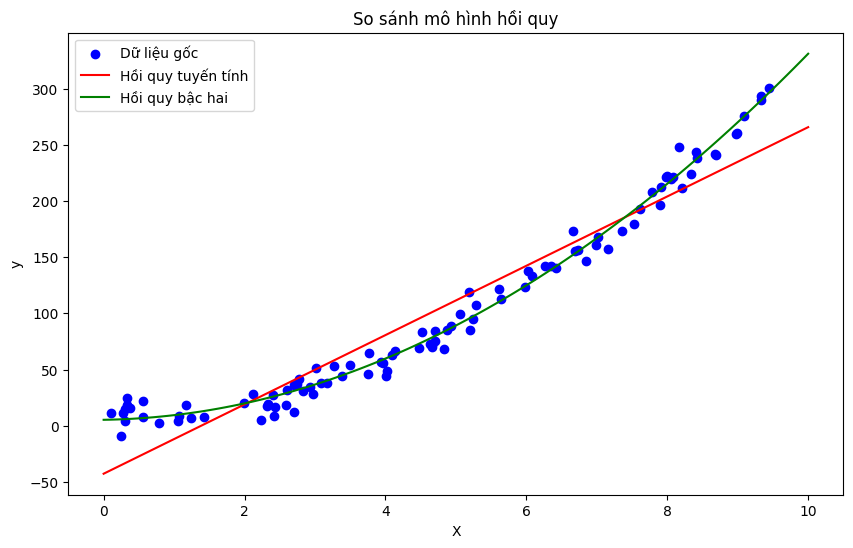

In [16]:
# Vẽ mô hình
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Dữ liệu gốc')
plt.plot(X_range, y_linear_pred, color='red', label='Hồi quy tuyến tính')
plt.plot(X_range, y_poly_pred, color='green', label='Hồi quy bậc hai')
plt.title('So sánh mô hình hồi quy')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()